In [84]:
import os
import pandas as pd
import numpy as np
import time
from datetime import datetime
from datetime import timedelta
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import ipywidgets as widgets

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import warnings

from tqdm import tqdm

from catboost import CatBoostClassifier, CatBoostRegressor
import xgboost as xgb
import eli5
import joblib

In [2]:
plt.rcParams["figure.figsize"] = (15, 5)
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', None)

PATH_TGE='../../data/tge/'

# Read data

In [405]:
%%time
df_tge=pd.read_parquet(f'{PATH_TGE}ml_tge.parquet').sort_index()
df_b_moc=pd.read_parquet(f'{PATH_TGE}ml_b_moc.parquet').sort_index()
df_g_moc=pd.read_parquet(f'{PATH_TGE}ml_g_moc.parquet').sort_index()
df_g_wiatr=pd.read_parquet(f'{PATH_TGE}ml_g_wiatr.parquet').sort_index()
df_i_net=pd.read_parquet(f'{PATH_TGE}ml_i_net.parquet').sort_index()
df_w_kse=pd.read_parquet(f'{PATH_TGE}ml_w_kse.parquet').sort_index()
df_w_ubytki=pd.read_parquet(f'{PATH_TGE}ml_w_ubytki.parquet').sort_index()
df_w_wym=pd.read_parquet(f'{PATH_TGE}ml_w_wym.parquet').sort_index()
df_weather_ml=pd.read_parquet(f'{PATH_TGE}ml_weather.parquet').sort_index()
df_z_kse=pd.read_parquet(f'{PATH_TGE}ml_z_kse.parquet').sort_index()

CPU times: total: 203 ms
Wall time: 142 ms


# Train Model & Predict

- "d" - at 9-00 "d" train model and predict target on "d+1"
- we know target on "d-1"
- we know features on "d-1" ("gen_moc", "bil_moc" on "d-2"), 
- we know features on "d-3"

1. Option1 (48h) (without "gen_moc", "bil_moc"):
- "train": features "d-3" + target "d-1"
- "predict": features "d-1" + predict_target "d+1"

2. Option2 (72h)  (with "gen_moc", "bil_moc"):
- "train": features "d-5" + target "d-2"
- "predict": features "d-2" + predict_target "d+1"

3. Option3 (48h) (with "gen_moc", "bil_moc"):
- "train": features "d-3" + ("gen_moc", "bil_moc" - shift(1day)) + target "d-1"
- "predict": features "d-1" + ("gen_moc", "bil_moc" - shift(1day)) + predict_target "d+1"

# SET Targets

- target1: fixing_1_kurs
- target2: growth_rate target1/fixing_1_kurs
- target3: binary classification. If target1>=1 then tartget3=1

In [406]:
df_tge['target48h_1']=df_tge['fixing_1_kurs'].shift(-48)
df_tge['target48h_2']=df_tge['target48h_1'].div(df_tge['fixing_1_kurs'])
df_tge['target48h_3']=np.where(df_tge['target48h_2']>=1,1,0)

df_tge['target72h_1']=df_tge['fixing_1_kurs'].shift(-72)
df_tge['target72h_2']=df_tge['target72h_1'].div(df_tge['fixing_1_kurs'])
df_tge['target72h_3']=np.where(df_tge['target72h_2']>=1,1,0)

df_tge.drop(['date','date_hour'],axis=1,inplace=True)

# MERGE Datasets

In [407]:
df_g_moc_tmp=df_g_moc.copy()
df_g_moc_tmp.index=df_g_moc_tmp['date_hour'].shift(-24)
df_b_moc_tmp=df_b_moc.resample('H').ffill().copy()
df_b_moc_tmp.index=df_b_moc_tmp.reset_index()['date_hour'].shift(-24)

In [408]:
df_48=pd.concat([df_tge,
           df_weather_ml.drop(['year','month','day','hour','yday'],axis=1),           
           df_w_kse.rename(columns={'Krajowe zapotrzebowanie na moc':'Krajowe_moc'}),   
           df_g_wiatr, df_i_net, df_w_ubytki, df_w_wym, df_z_kse
          ],axis=1)

In [413]:
df_48_1=pd.concat([df_tge,
           df_weather_ml.drop(['year','month','day','hour','yday'],axis=1),
           df_g_moc_tmp[:-24].drop('date_hour',axis=1),
           df_b_moc_tmp[:-24],
           df_w_kse.rename(columns={'Krajowe zapotrzebowanie na moc':'Krajowe_moc'}),   
           df_g_wiatr, df_i_net, df_w_ubytki, df_w_wym, df_z_kse
          ],axis=1)

In [410]:
df_72=pd.concat([df_tge,
           df_weather_ml.drop(['year','month','day','hour','yday'],axis=1),
           df_g_moc.drop(['date_hour'],axis=1),
           df_b_moc.resample('H').ffill(),
           df_w_kse.rename(columns={'Krajowe zapotrzebowanie na moc':'Krajowe_moc'}),   
           df_g_wiatr, df_i_net, df_w_ubytki, df_w_wym, df_z_kse
          ],axis=1)

In [411]:
ver1_min_date='2019-06-28 00:00:00'  # >=
ver1_max_date='2022-10-26 23:59:00'  # <
ver2_min_date='2020-02-18 00:00:00'  # >=
ver2_max_date='2022-10-26 23:59:00'  # <

df_48_v=df_48[ver1_min_date :ver1_max_date].copy()
df_48_v.fillna(0, inplace=True)
print(df_48_v.shape)
df_48_v.head(2)

(29208, 114)


,czas,fixing_1_kurs,fixing_1_wolumen,fixing_2_kurs,fixing_2_wolumen,notowania_kurs,notowania_wolumen,target48h_1,target48h_2,target48h_3,target72h_1,target72h_2,target72h_3,Main,Description,wday,wind_deg,clouds,ID,wind_speed,dew_point,humidity,feels_like,pressure,temp,Krajowe_moc,Sumaryczna generacja JWCD,Generacja PI,Generacja IRZ,Sumaryczna generacja nJWCD,Krajowe saldo wymiany miêdzysystemowej równoleg³ej,Krajowe saldo wymiany miêdzysystemowej nierównoleg³ej,gen_wiatr,gen_fotowolt,energia_frr_export,energia_frr_import,frr_export,frr_import,frr_export_eur,frr_import_eur,dostep_ubytki_ADM,dostep_ubytki_BEL,dostep_ubytki_DOD,dostep_ubytki_JW2,dostep_ubytki_JW3,dostep_ubytki_KAR,dostep_ubytki_KOZ,dostep_ubytki_LGA,dostep_ubytki_LZA,dostep_ubytki_OPL,dostep_ubytki_OSB,dostep_ubytki_PAT,dostep_ubytki_PLO,dostep_ubytki_POL,dostep_ubytki_RYB,dostep_ubytki_SIA,dostep_ubytki_STW,dostep_ubytki_TUR,dostep_ubytki_WLC,dostep_ubytki_WZE,elektro_ubytki_ADM,elektro_ubytki_BEL,elektro_ubytki_DOD,elektro_ubytki_JW2,elektro_ubytki_JW3,elektro_ubytki_KAR,elektro_ubytki_KOZ,elektro_ubytki_LGA,elektro_ubytki_LZA,elektro_ubytki_OPL,elektro_ubytki_OSB,elektro_ubytki_PAT,elektro_ubytki_PLO,elektro_ubytki_POL,elektro_ubytki_RYB,elektro_ubytki_SIA,elektro_ubytki_STW,elektro_ubytki_TUR,elektro_ubytki_WLC,elektro_ubytki_WZE,siec_ubytki_ADM,siec_ubytki_BEL,siec_ubytki_DOD,siec_ubytki_JW2,siec_ubytki_JW3,siec_ubytki_KAR,siec_ubytki_KOZ,siec_ubytki_LGA,siec_ubytki_LZA,siec_ubytki_OPL,siec_ubytki_OSB,siec_ubytki_PAT,siec_ubytki_PLO,siec_ubytki_POL,siec_ubytki_RYB,siec_ubytki_SIA,siec_ubytki_STW,siec_ubytki_TUR,siec_ubytki_WLC,siec_ubytki_WZE,CEPS_EXP,CEPS_IMP,SEPS_EXP,SEPS_IMP,50HzT_EXP,50HzT_IMP,SVK_EXP,SVK_IMP,UA_EXP,UA_IMP,LIT_EXP,LIT_IMP,demand_forecast,demand_fact
2019-06-28 00:00:00,1.0,220.54,1754.3,226.53,1245.7,0.0,5.0,193.95,0.879432,0.0,230.99,1.047384,1.0,Clear,clear sky,4.0,340.0,0.0,800.0,2.6,10.70,65.0,16.83,1020.0,17.34,16989.913,10774.063,-11.65,0.0,4167.675,792.475,1275.288,1375.780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220.0,0.0,0.0,606.0,0.0,180.0,540.0,0.0,0.0,0.0,0.0,100.0,434.0,0.0,0.0,1120.0,215.0,910.0,0.0,212.0,1356.0,460.0,0.0,1068.0,0.0,200.0,90.0,709.0,450.0,0.0,125.0,605.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-468.4,23.8,-264.0,0.0,0.0,1475.65,0.0,597.6,0.0,148.549,0.0,484.99,16900.0,16989.913
2019-06-28 01:00:00,2.0,203.85,1674.0,191.84,1277.3,0.0,0.0,188.00,0.922247,0.0,230.99,1.133137,1.0,Clear,clear sky,4.0,340.0,0.0,800.0,2.6,11.05,71.0,15.85,1020.0,16.31,16355.463,10466.125,-53.40,0.0,4095.663,708.175,1142.388,1288.941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.4,0.0,0.0,0.0,220.0,0.0,0.0,606.0,0.0,180.0,540.0,0.0,0.0,0.0,0.0,100.0,434.0,0.0,0.0,1120.0,180.6,910.0,0.0,212.0,1356.0,460.0,0.0,1068.0,0.0,200.0,90.0,709.0,450.0,0.0,125.0,605.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-471.7,21.4,-169.0,0.0,0.0,1315.60,0.0,597.6,0.0,147.496,0.0,345.82,16100.0,16355.463


In [412]:
df_72_v=df_72[ver1_min_date :ver1_max_date].copy()
df_72_v.fillna(0, inplace=True)
print(df_72_v.shape)
df_72_v.head(2)

(29208, 202)


,czas,fixing_1_kurs,fixing_1_wolumen,fixing_2_kurs,fixing_2_wolumen,notowania_kurs,notowania_wolumen,target48h_1,target48h_2,target48h_3,target72h_1,target72h_2,target72h_3,Main,Description,wday,wind_deg,clouds,ID,wind_speed,dew_point,humidity,feels_like,pressure,temp,Gen_ADM,Gen_BEL,Gen_CHZ,Gen_DCH,Gen_DOD,Gen_JW2,Gen_JW3,Gen_KAR,Gen_KAT,Gen_KLE,Gen_KOZ,Gen_LD4,Gen_LEC,Gen_LGA,Gen_LZA,Gen_OPL,Gen_OSB,Gen_PAT,Gen_PLO,Gen_POL,Gen_PZR,Gen_REC,Gen_RYB,Gen_SIA,Gen_SNA,Gen_SOL,Gen_STW,Gen_TUR,Gen_WLC,Gen_WRO,Gen_WSI,Gen_WZE,Gen_ZGR,Gen_ZRN,Gen_ZYD,Pom_DCH,Pom_PZR,Pom_SOL,Pom_ZRN,Pom_ZYD,Moc osi¹galna elektrowni krajowych,Elektrownie zawodowe,JWCD,pozosta³e,elektrownie przemys³owe,Ubytki mocy elektrowni przemys³owych,Ubytki mocy elektrowni zawodowych,spowodowane remontami kapitalnymi,JWCD.1,pozosta³e.1,spowodowane remontami rednimi,JWCD.2,pozosta³e.2,spowodowane remontami bie¿¹cymi,JWCD.3,pozosta³e.3,spowodowane remontami awaryjnymi,JWCD.4,pozosta³e.4,spowodowane warunkami eksploatacyjnymi,JWCD.5,pozosta³e.5,ze wzglêdu na ciep³ownictwo,JWCD.6,pozosta³e.6,na JW bedacych w okresie oswajania z inwestycji,JWCD.7,pozosta³e.7,Moc dyspozycyjna elektrowni krajowych,elektrownie zawodowe,JWCD.8,pozosta³e.8,elektrownie przemys³owe.1,Obci¹¿enie elektrowni krajowych,elektrownie zawodowe.1,JWCD.9,pozosta³e.9,elektrownie przemys³owe.2,Krajowe zapotrzebowanie na moc,Krajowe saldo wymiany miêdzysystemowej *,Ubytki mocy z uwagi na warunki pracy sieci,Rezerwa mocy w elektrowniach zawodowych:**,Rezerwa mocy w JWCD,JWCD cieplne:,rezerwa wiruj¹ca,rezerwa zimna,JWCD wodne,Rezerwa mocy pozosta³a,Krajowe_moc,Sumaryczna generacja JWCD,Generacja PI,Generacja IRZ,Sumaryczna generacja nJWCD,Krajowe saldo wymiany miêdzysystemowej równoleg³ej,Krajowe saldo wymiany miêdzysystemowej nierównoleg³ej,gen_wiatr,gen_fotowolt,energia_frr_export,energia_frr_import,frr_export,frr_import,frr_export_eur,frr_import_eur,dostep_ubytki_ADM,dostep_ubytki_BEL,dostep_ubytki_DOD,dostep_ubytki_JW2,dostep_ubytki_JW3,dostep_ubytki_KAR,dostep_ubytki_KOZ,dostep_ubytki_LGA,dostep_ubytki_LZA,dostep_ubytki_OPL,dostep_ubytki_OSB,dostep_ubytki_PAT,dostep_ubytki_PLO,dostep_ubytki_POL,dostep_ubytki_RYB,dostep_ubytki_SIA,dostep_ubytki_STW,dostep_ubytki_TUR,dostep_ubytki_WLC,dostep_ubytki_WZE,elektro_ubytki_ADM,elektro_ubytki_BEL,elektro_ubytki_DOD,elektro_ubytki_JW2,elektro_ubytki_JW3,elektro_ubytki_KAR,elektro_ubytki_KOZ,elektro_ubytki_LGA,elektro_ubytki_LZA,elektro_ubytki_OPL,elektro_ubytki_OSB,elektro_ubytki_PAT,elektro_ubytki_PLO,elektro_ubytki_POL,elektro_ubytki_RYB,elektro_ubytki_SIA,elektro_ubytki_STW,elektro_ubytki_TUR,elektro_ubytki_WLC,elektro_ubytki_WZE,siec_ubytki_ADM,siec_ubytki_BEL,siec_ubytki_DOD,siec_ubytki_JW2,siec_ubytki_JW3,siec_ubytki_KAR,siec_ubytki_KOZ,siec_ubytki_LGA,siec_ubytki_LZA,siec_ubytki_OPL,siec_ubytki_OSB,siec_ubytki_PAT,siec_ubytki_PLO,siec_ubytki_POL,siec_ubytki_RYB,siec_ubytki_SIA,siec_ubytki_STW,siec_ubytki_TUR,siec_ubytki_WLC,siec_ubytki_WZE,CEPS_EXP,CEPS_IMP,SEPS_EXP,SEPS_IMP,50HzT_EXP,50HzT_IMP,SVK_EXP,SVK_IMP,UA_EXP,UA_IMP,LIT_EXP,LIT_IMP,demand_forecast,demand_fact
2019-06-28 00:00:00,1.0,220.54,1754.3,226.53,1245.7,0.0,5.0,193.95,0.879432,0.0,230.99,1.047384,1.0,Clear,clear sky,4.0,340.0,0.0,800.0,2.6,10.70,65.0,16.83,1020.0,17.34,0.0,2309.76,85.030,0.0,316.33,0.0,390.1,0.0,98.154,66.739,1554.10,0.0,0.0,0.0,538.28,1234.66,282.64,544.55,532.64,749.34,0.0,0.0,654.28,180.3,90.96,0.0,84.6,395.54,420.74,0.0,0.0,0.0,167.368,0.0,0.0,0.0,0.2,0.27,12.78,0.68,46351.5,43628.87,29483.0,14145.87,2722.63,1684.63,18283.61,3597.2,3098.0,499.2,2163.2,763.0,1400.2,851.2,404.0,447.2,906.55,861.55,45.0,8173.23,1635.2,6538.03,1229.73,0.0,1229.73,1362.5,1362.5,0.0,26396.96,25358.96,21372.45,3986.51,1038.0,19176.15,18138.15,14880.0,3258.15,1038.0,21436.332,2267.75,573.0,6647.81,5919.45,4771.55,2557.55,2214.0,1147.9,728.36,16989.913,10774.063,-11.65,0.0,4167.675,792.475,1275.288,1375.780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220.0,0.0,0.0,606.0,0.0,180.0,540.0,0.

In [414]:
df_48_1_v=df_48_1[ver1_min_date :ver1_max_date].copy()
df_48_1_v.fillna(0, inplace=True)
print(df_48_1_v.shape)
df_48_1_v.head(2)

(29208, 202)


,czas,fixing_1_kurs,fixing_1_wolumen,fixing_2_kurs,fixing_2_wolumen,notowania_kurs,notowania_wolumen,target48h_1,target48h_2,target48h_3,target72h_1,target72h_2,target72h_3,Main,Description,wday,wind_deg,clouds,ID,wind_speed,dew_point,humidity,feels_like,pressure,temp,Gen_ADM,Gen_BEL,Gen_CHZ,Gen_DCH,Gen_DOD,Gen_JW2,Gen_JW3,Gen_KAR,Gen_KAT,Gen_KLE,Gen_KOZ,Gen_LD4,Gen_LEC,Gen_LGA,Gen_LZA,Gen_OPL,Gen_OSB,Gen_PAT,Gen_PLO,Gen_POL,Gen_PZR,Gen_REC,Gen_RYB,Gen_SIA,Gen_SNA,Gen_SOL,Gen_STW,Gen_TUR,Gen_WLC,Gen_WRO,Gen_WSI,Gen_WZE,Gen_ZGR,Gen_ZRN,Gen_ZYD,Pom_DCH,Pom_PZR,Pom_SOL,Pom_ZRN,Pom_ZYD,Moc osi¹galna elektrowni krajowych,Elektrownie zawodowe,JWCD,pozosta³e,elektrownie przemys³owe,Ubytki mocy elektrowni przemys³owych,Ubytki mocy elektrowni zawodowych,spowodowane remontami kapitalnymi,JWCD.1,pozosta³e.1,spowodowane remontami rednimi,JWCD.2,pozosta³e.2,spowodowane remontami bie¿¹cymi,JWCD.3,pozosta³e.3,spowodowane remontami awaryjnymi,JWCD.4,pozosta³e.4,spowodowane warunkami eksploatacyjnymi,JWCD.5,pozosta³e.5,ze wzglêdu na ciep³ownictwo,JWCD.6,pozosta³e.6,na JW bedacych w okresie oswajania z inwestycji,JWCD.7,pozosta³e.7,Moc dyspozycyjna elektrowni krajowych,elektrownie zawodowe,JWCD.8,pozosta³e.8,elektrownie przemys³owe.1,Obci¹¿enie elektrowni krajowych,elektrownie zawodowe.1,JWCD.9,pozosta³e.9,elektrownie przemys³owe.2,Krajowe zapotrzebowanie na moc,Krajowe saldo wymiany miêdzysystemowej *,Ubytki mocy z uwagi na warunki pracy sieci,Rezerwa mocy w elektrowniach zawodowych:**,Rezerwa mocy w JWCD,JWCD cieplne:,rezerwa wiruj¹ca,rezerwa zimna,JWCD wodne,Rezerwa mocy pozosta³a,Krajowe_moc,Sumaryczna generacja JWCD,Generacja PI,Generacja IRZ,Sumaryczna generacja nJWCD,Krajowe saldo wymiany miêdzysystemowej równoleg³ej,Krajowe saldo wymiany miêdzysystemowej nierównoleg³ej,gen_wiatr,gen_fotowolt,energia_frr_export,energia_frr_import,frr_export,frr_import,frr_export_eur,frr_import_eur,dostep_ubytki_ADM,dostep_ubytki_BEL,dostep_ubytki_DOD,dostep_ubytki_JW2,dostep_ubytki_JW3,dostep_ubytki_KAR,dostep_ubytki_KOZ,dostep_ubytki_LGA,dostep_ubytki_LZA,dostep_ubytki_OPL,dostep_ubytki_OSB,dostep_ubytki_PAT,dostep_ubytki_PLO,dostep_ubytki_POL,dostep_ubytki_RYB,dostep_ubytki_SIA,dostep_ubytki_STW,dostep_ubytki_TUR,dostep_ubytki_WLC,dostep_ubytki_WZE,elektro_ubytki_ADM,elektro_ubytki_BEL,elektro_ubytki_DOD,elektro_ubytki_JW2,elektro_ubytki_JW3,elektro_ubytki_KAR,elektro_ubytki_KOZ,elektro_ubytki_LGA,elektro_ubytki_LZA,elektro_ubytki_OPL,elektro_ubytki_OSB,elektro_ubytki_PAT,elektro_ubytki_PLO,elektro_ubytki_POL,elektro_ubytki_RYB,elektro_ubytki_SIA,elektro_ubytki_STW,elektro_ubytki_TUR,elektro_ubytki_WLC,elektro_ubytki_WZE,siec_ubytki_ADM,siec_ubytki_BEL,siec_ubytki_DOD,siec_ubytki_JW2,siec_ubytki_JW3,siec_ubytki_KAR,siec_ubytki_KOZ,siec_ubytki_LGA,siec_ubytki_LZA,siec_ubytki_OPL,siec_ubytki_OSB,siec_ubytki_PAT,siec_ubytki_PLO,siec_ubytki_POL,siec_ubytki_RYB,siec_ubytki_SIA,siec_ubytki_STW,siec_ubytki_TUR,siec_ubytki_WLC,siec_ubytki_WZE,CEPS_EXP,CEPS_IMP,SEPS_EXP,SEPS_IMP,50HzT_EXP,50HzT_IMP,SVK_EXP,SVK_IMP,UA_EXP,UA_IMP,LIT_EXP,LIT_IMP,demand_forecast,demand_fact
2019-06-28 00:00:00,1.0,220.54,1754.3,226.53,1245.7,0.0,5.0,193.95,0.879432,0.0,230.99,1.047384,1.0,Clear,clear sky,4.0,340.0,0.0,800.0,2.6,10.70,65.0,16.83,1020.0,17.34,0.0,3388.98,85.091,0.0,216.92,0.0,288.8,62.686,98.441,85.853,1764.26,0.0,0.0,0.0,616.39,1010.34,174.22,656.92,478.22,1034.20,62.8,0.0,694.55,242.6,91.25,0.0,76.2,471.00,400.68,0.0,0.0,0.0,86.825,96.96,0.0,0.0,0.1,0.24,12.65,1.89,46351.5,43628.87,29483.0,14145.87,2722.63,1729.88,16504.46,3490.8,2991.6,499.2,2120.2,763.0,1357.2,887.2,440.0,447.2,1187.0,966.0,221.0,6181.58,981.65,5199.93,1275.18,0.0,1275.18,1362.5,1362.5,0.0,28123.11,27130.36,21984.2,5146.16,992.75,20123.7,19130.95,14588.7,4542.25,992.75,21956.166,1835.1,1165.0,6834.41,6230.5,5028.85,2380.35,2648.5,1201.65,603.91,16989.913,10774.063,-11.65,0.0,4167.675,792.475,1275.288,1375.780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220.0,0.0,0.0,606.0,0.0,180.0,540.

In [228]:
from sklearn.dummy import DummyRegressor, DummyClassifier

def split_dataset(df,target):
    feats = list(df.drop(['target48h_1','target48h_2','target48h_3','target72h_1','target72h_2','target72h_3'], axis=1).columns) 
    X = df[feats]
    y = df[target]
    return X,y
    
def dummy_regressor(df, target):
    X,y = split_dataset(df,target)
    list_strategy=['mean','median']
    for item_strategy in list_strategy:
        model = DummyRegressor(strategy=item_strategy)
        model.fit(X, y)
        y_pred = model.predict(X)
        print(f'Dummy-regr-{item_strategy}: ',mean_absolute_error(y, y_pred))

def dummy_classifier(df, target):
    X,y = split_dataset(df,target)
    list_strategy=['most_frequent','prior', 'stratified', 'uniform']
    for item_strategy in list_strategy:
        model = DummyClassifier(strategy=item_strategy)
        model.fit(X, y)
        print(f'Dummy-class-{item_strategy}: ',model.score(X, y))

In [229]:
dummy_regressor(df_48_v, "target48h_1")

Dummy-regr-mean:  224.88651727560486
Dummy-regr-median:  199.05819159134484


In [230]:
dummy_regressor(df_48_v, "target48h_2")

Dummy-regr-mean:  0.22460876920494782
Dummy-regr-median:  0.21875015192382324


In [231]:
dummy_classifier(df_48_v, "target48h_3")

Dummy-class-most_frequent:  0.503526431114763
Dummy-class-prior:  0.503526431114763
Dummy-class-stratified:  0.5062311695425911
Dummy-class-uniform:  0.5031840591618735


In [232]:
dummy_regressor(df_72_v, "target72h_1")

Dummy-regr-mean:  224.93014111379082
Dummy-regr-median:  199.21830320460145


In [233]:
dummy_regressor(df_72_v, "target72h_2")

Dummy-regr-mean:  0.23455871502128217
Dummy-regr-median:  0.22898513883207464


In [234]:
dummy_classifier(df_72_v, "target72h_3")

Dummy-class-most_frequent:  0.5066077786907697
Dummy-class-prior:  0.5066077786907697
Dummy-class-stratified:  0.5009586414680909
Dummy-class-uniform:  0.49763763352506163


In [348]:
def check_log_model_class(df, feats, column_label, model, count_between=24, cv=4, scoring=confusion_matrix):
    COUNT_ROW_IN_SLICE_CV=24
    COUNT_ROW_IN_TEST=24
    COUNT_ROW_BETWEEN_TRAIN_AND_TEST=count_between

    X = df[feats]
    y = df[column_label]
    
    scores = []
    accuracys=[]
    nda=np.array([[0, 0], [0, 0]])
    df_predicted=pd.DataFrame()

    for cv_idx in tqdm(range(1,cv+1)):
        test_idx_end=COUNT_ROW_IN_SLICE_CV*cv_idx
        test_idx_start=test_idx_end+COUNT_ROW_IN_TEST
        train_idx=test_idx_start+COUNT_ROW_BETWEEN_TRAIN_AND_TEST  
        
        X_train, X_test = X.iloc[:-train_idx], X.iloc[-test_idx_start:-test_idx_end]
        y_train, y_test = y.iloc[:-train_idx], y.iloc[-test_idx_start:-test_idx_end]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
                
        score = scoring(y_test, y_pred, labels=model.classes_)
   #     print(score)
   #     print(y_test)
   #     print(y_pred)
        nda=nda+np.array(score)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracys.append(accuracy)

        df_temp=pd.concat([pd.DataFrame(y_test).reset_index(),pd.DataFrame(y_pred_proba).rename(columns={1:'y_pred_proba', 0:'tmp'}).drop('tmp',axis=1)], axis=1)
        df_predicted=pd.concat([df_predicted,df_temp])
        
    df_predicted=df_predicted.set_index('index').sort_index()  
        
        
    result= np.mean(accuracys), nda
    
    
    sns.heatmap(nda, annot=True, fmt='d', cmap='Blues')
    
    model.fit(X, y)
    print(result)

    return result, eli5.show_weights(model, feature_names=feats), df_predicted

In [263]:
def check_log_model_regr(df, feats, column_label, model, count_between=24, cv=4, scoring=mean_absolute_error):
    COUNT_ROW_IN_SLICE_CV=24
    COUNT_ROW_IN_TEST=24
    COUNT_ROW_BETWEEN_TRAIN_AND_TEST=count_between

    X = df[feats]
    y = df[column_label]
    y_log = np.log(y)
   
    scores = []
    df_predicted=pd.DataFrame()
    for cv_idx in tqdm(range(1,cv+1)):
        test_idx_end=COUNT_ROW_IN_SLICE_CV*cv_idx
        test_idx_start=test_idx_end+COUNT_ROW_IN_TEST
        train_idx=test_idx_start+COUNT_ROW_BETWEEN_TRAIN_AND_TEST        
        
        X_train, X_test = X.iloc[:-train_idx], X.iloc[-test_idx_start:-test_idx_end]
        y_log_train, y_test = y_log.iloc[:-train_idx], y.iloc[-test_idx_start:-test_idx_end]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)
        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
        df_temp=pd.concat([pd.DataFrame(y_test).reset_index(),pd.DataFrame(y_pred).rename(columns={0:'y_pred'})], axis=1)
        df_predicted=pd.concat([df_predicted,df_temp])
        
    df_predicted=df_predicted.set_index('index').sort_index()  
    sns.lineplot(data=df_predicted);
    
    result = np.mean(scores), np.std(scores)

    model.fit(X, y_log)
    print(result)

    return result, eli5.show_weights(model, feature_names=feats), df_predicted

In [238]:
list_targets=['target48h_1','target48h_2','target48h_3','target72h_1','target72h_2','target72h_3']

## Target1 - 48/72H/48v3 - Catboost/XGBoost

- without "gen_moc", "bil_moc" models is bad

### Catboost

100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


(145.17494544572827, 91.59110485378827)


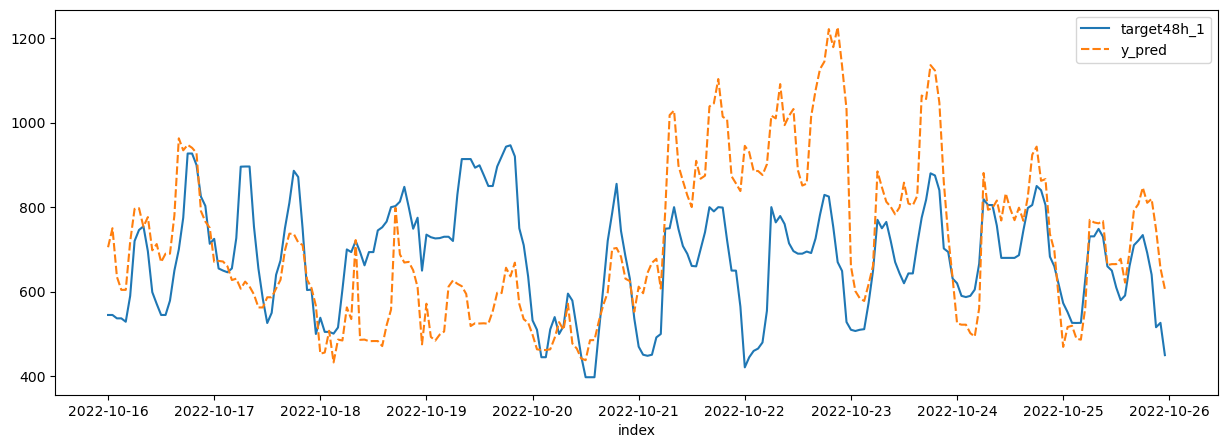

In [265]:
feats = list(df_48_v.drop(list_targets, axis=1).columns) 
col_target='target48h_1'
col_cat=['Main','Description']
result, eli_result, df_predicted = check_log_model_regr(df_48_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=50, loss_function='RMSE', learning_rate=0.3, random_state=0, verbose=False, cat_features=col_cat), cv=10)

100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


(145.6688925788445, 87.72463503711826)


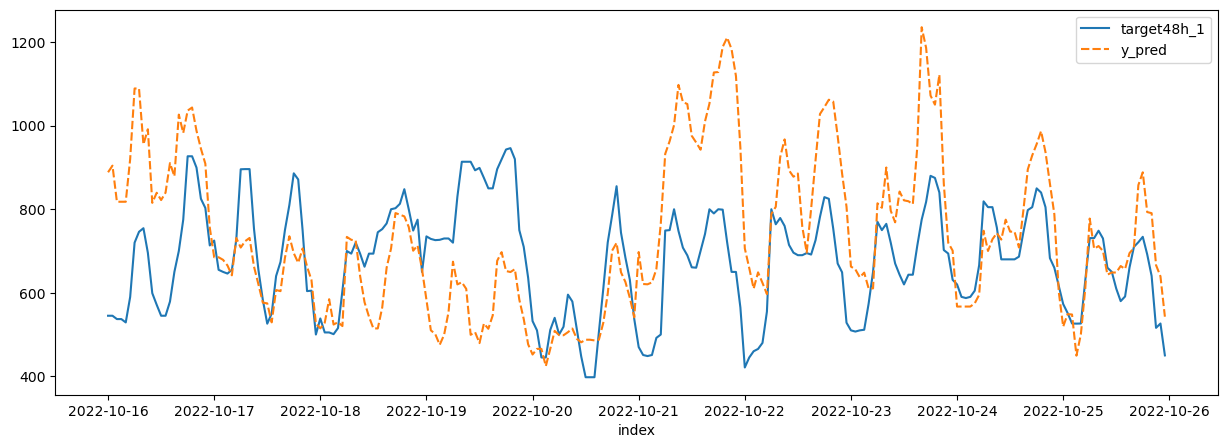

In [267]:
feats = list(df_48_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_1'
result, eli_result, df_predicted = check_log_model_regr(df_48_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=50, loss_function='RMSE', learning_rate=0.3, random_state=0, verbose=False), cv=10)

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


(130.90112730886023, 63.43436149600939)


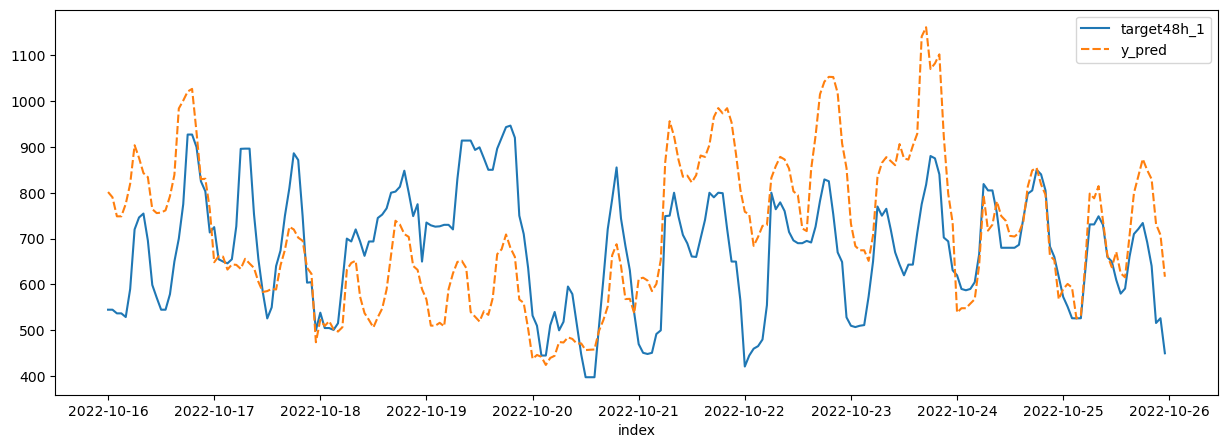

In [289]:
feats = list(df_48_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_1'
result, eli_result, df_predicted = check_log_model_regr(df_48_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=100, loss_function='RMSE', learning_rate=0.1, random_state=0, verbose=False), cv=10)

100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


(96.62590054166834, 29.31986624209624)


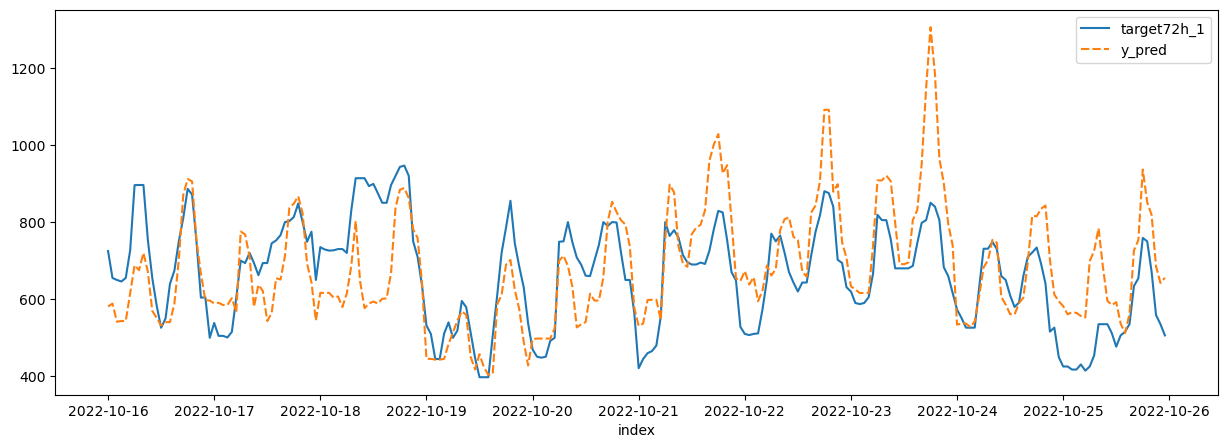

In [283]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_1'
result, eli_result, df_predicted = check_log_model_regr(df_72_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=50, loss_function='RMSE', learning_rate=0.3, random_state=0, verbose=False), count_between=48, cv=10)

100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


(88.61334367812943, 51.77087692734526)


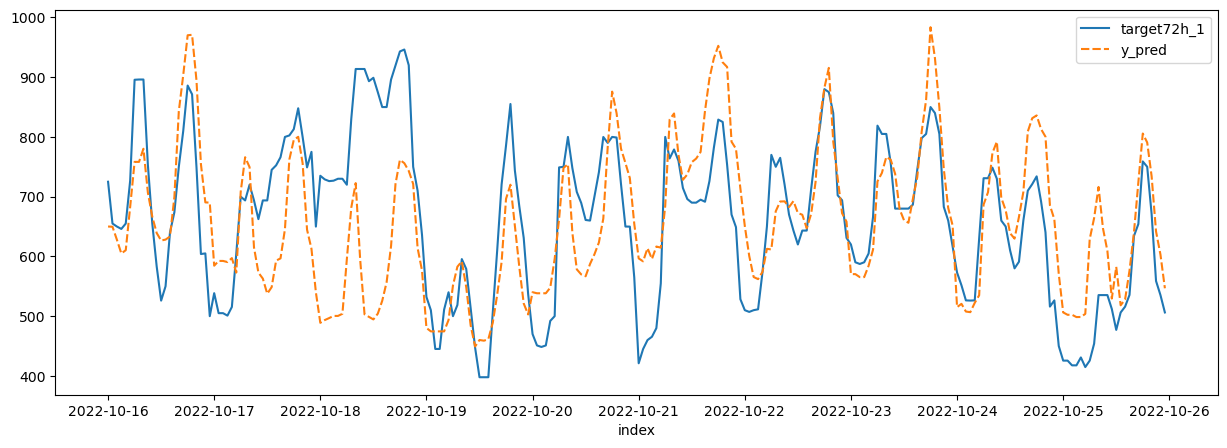

In [288]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_1'
result, eli_result, df_predicted = check_log_model_regr(df_72_v, feats, col_target, 
    CatBoostRegressor(depth=4, iterations=100, loss_function='RMSE', learning_rate=0.1, random_state=0, verbose=False), count_between=48, cv=10)

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


(104.74241259567376, 50.73463808073443)


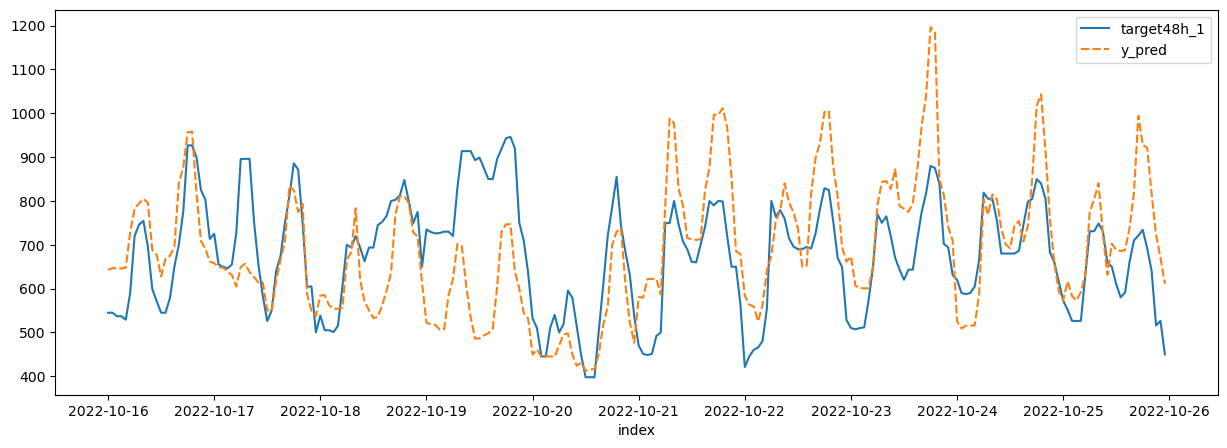

In [416]:
feats = list(df_48_1_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_1'
result, eli_result, df_predicted = check_log_model_regr(df_48_1_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=50, loss_function='RMSE', learning_rate=0.3, random_state=0, verbose=False), cv=10)

100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


(96.26882961115173, 50.64589114118441)


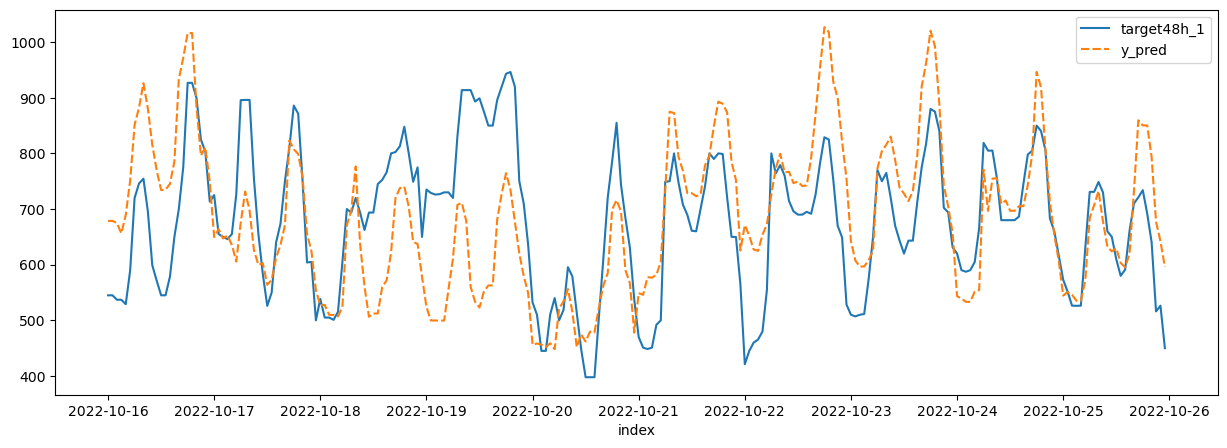

In [423]:
feats = list(df_48_1_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_1'
result, eli_result, df_predicted = check_log_model_regr(df_48_1_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=50, loss_function='RMSE', learning_rate=0.15, random_state=0, verbose=False), cv=10)

### XGBoost

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


(139.5975639292399, 92.5890859851169)


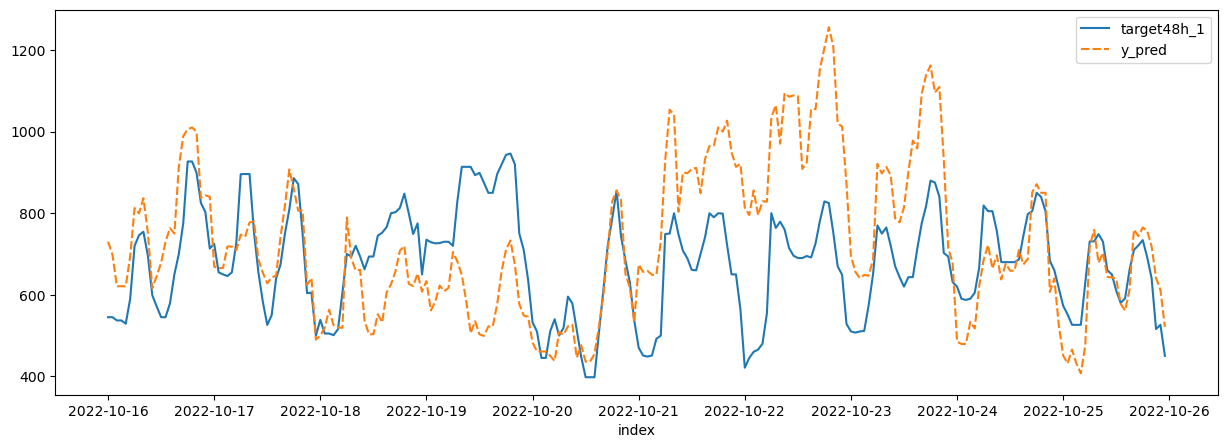

In [295]:
feats = list(df_48_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_1'
result, eli_result, df_predicted = check_log_model_regr(df_48_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), cv=10)

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


(118.76025527954103, 60.41161598117518)


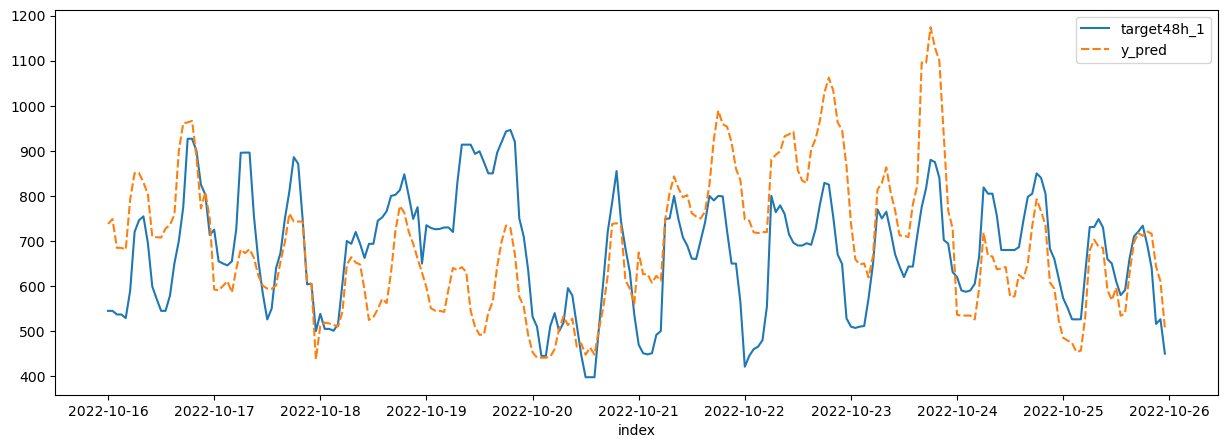

In [296]:
feats = list(df_48_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_1'
result, eli_result, df_predicted = check_log_model_regr(df_48_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.1, random_state=0), cv=10)

100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


(126.44800607808432, 76.53632366473717)


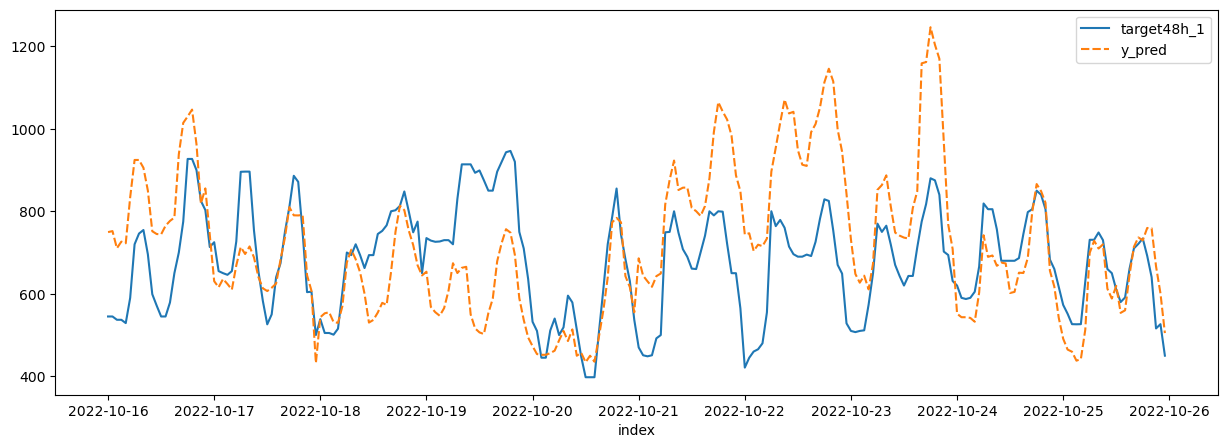

In [298]:
feats = list(df_48_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_1'
result, eli_result, df_predicted = check_log_model_regr(df_48_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, random_state=0), cv=10)

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


(108.21551112365721, 53.959060598584514)


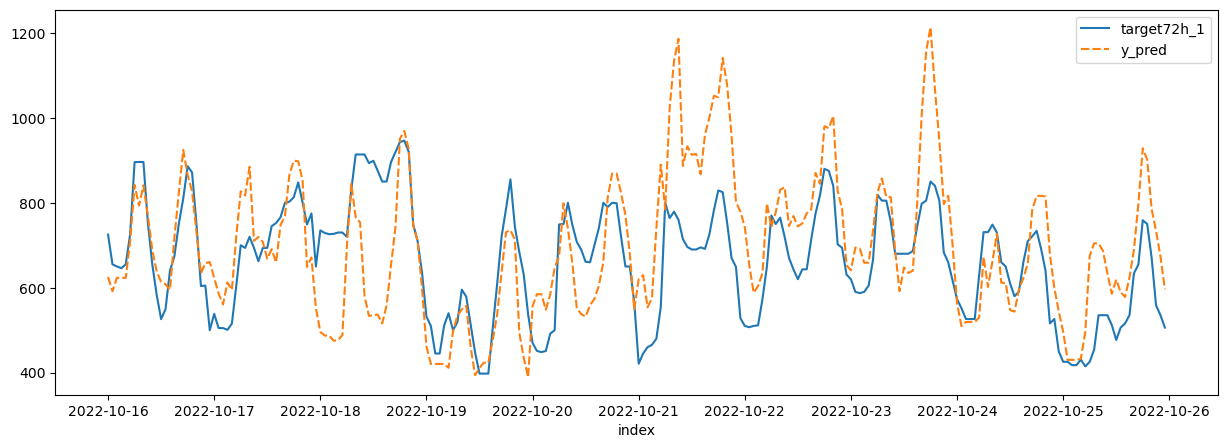

In [299]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_1'
result, eli_result, df_predicted = check_log_model_regr(df_72_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), count_between=48, cv=10)

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


(84.12729558817546, 43.29775639213897)


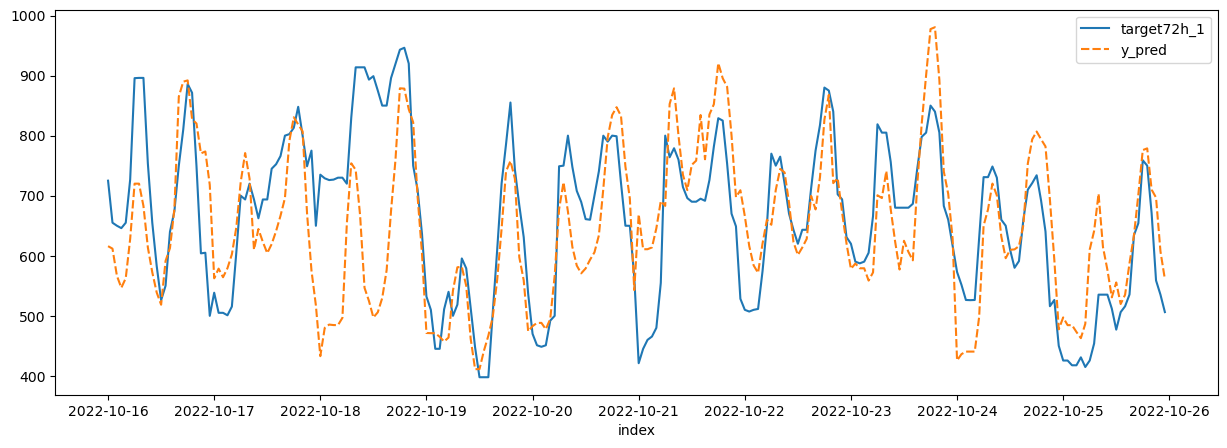

In [302]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_1'
result, eli_result, df_predicted = check_log_model_regr(df_72_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=6, n_estimators=50, learning_rate=0.1, random_state=0), count_between=48, cv=10)

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


(108.49955294291178, 41.20092243025749)


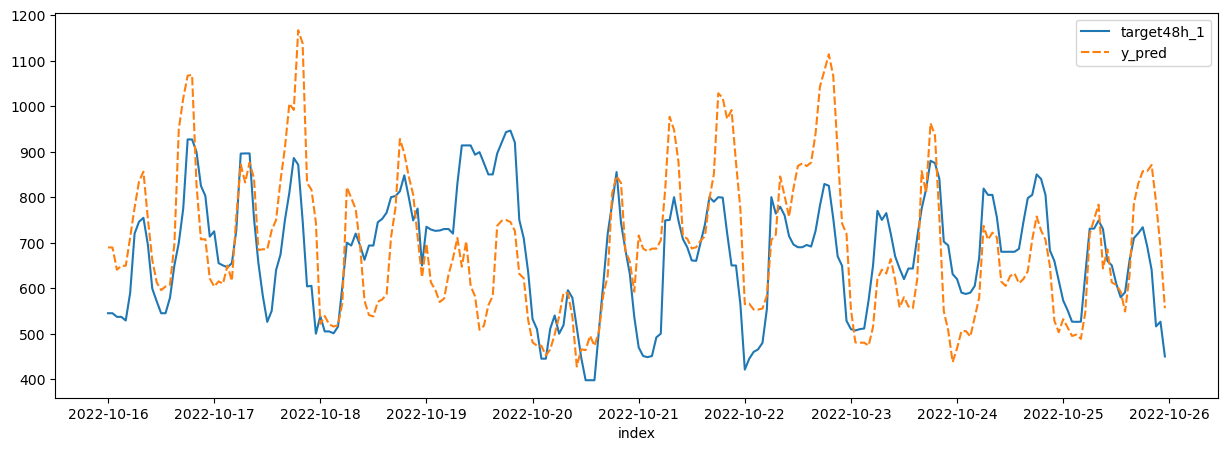

In [430]:
feats = list(df_48_1_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_1'
result, eli_result, df_predicted = check_log_model_regr(df_48_1_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), cv=10)

## Target2 - 48/72H/48v3 - Catboost/XGBoost

100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


(0.21295674689743976, 0.14074391906995057)


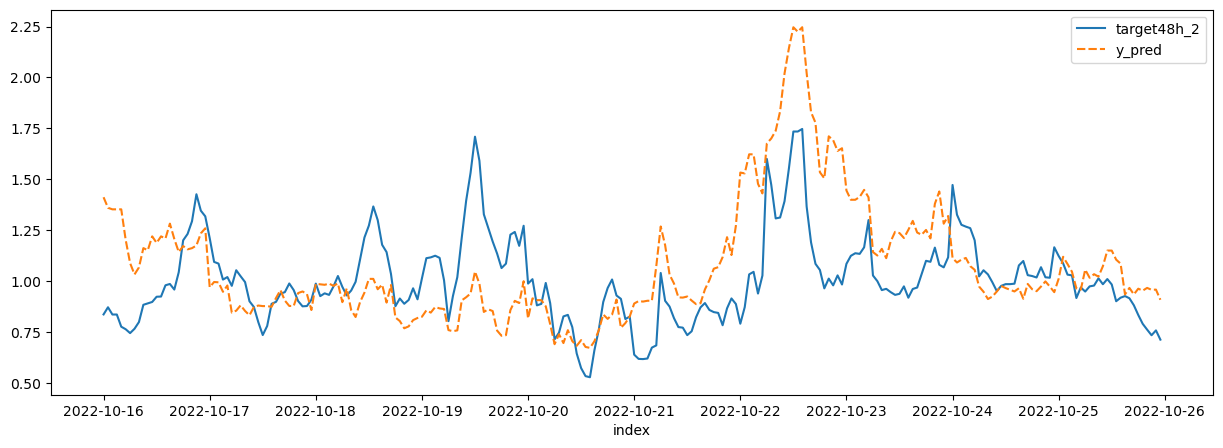

In [311]:
feats = list(df_48_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_2'
result, eli_result, df_predicted = check_log_model_regr(df_48_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=50, loss_function='RMSE', learning_rate=0.3, random_state=0, verbose=False), cv=10)

100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


(0.1783845313585682, 0.0830238298498441)


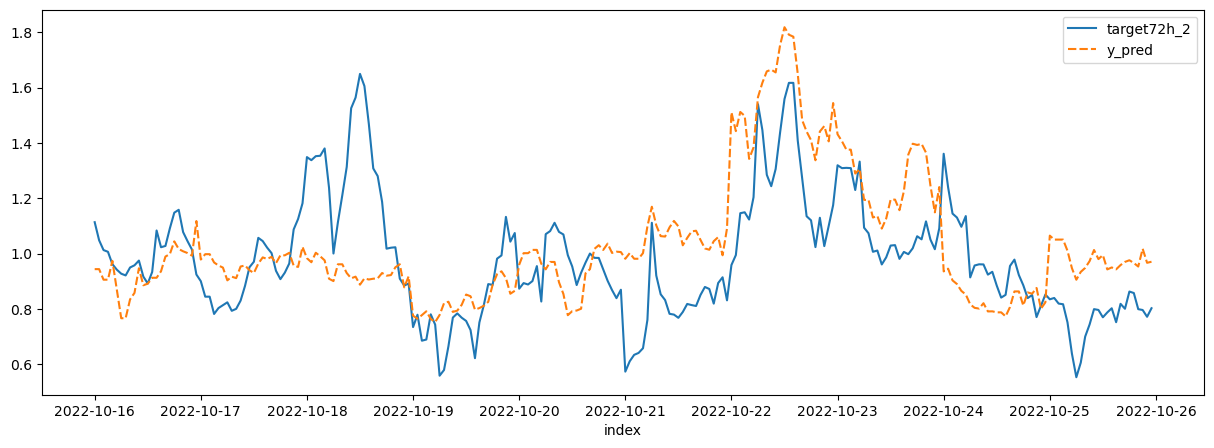

In [318]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_2'
result, eli_result, df_predicted = check_log_model_regr(df_72_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=50, loss_function='RMSE', learning_rate=0.3, random_state=0, verbose=False), count_between=48, cv=10)

100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


(0.12860598581035226, 0.07851302585160776)


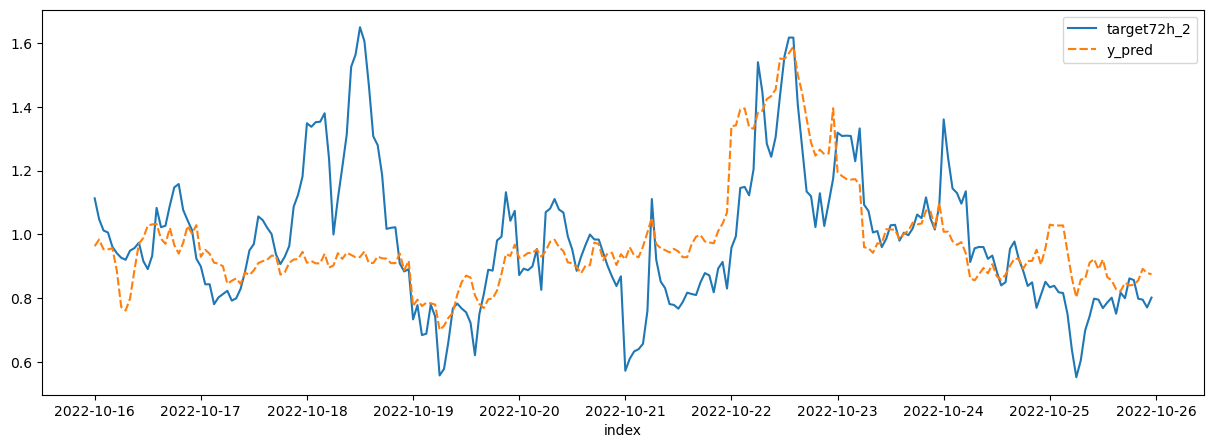

In [321]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_2'
result, eli_result, df_predicted = check_log_model_regr(df_72_v, feats, col_target, 
    CatBoostRegressor(depth=6, iterations=100, loss_function='RMSE', learning_rate=0.1, random_state=0, verbose=False), count_between=48, cv=10)

100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


(0.15426703355077634, 0.07918146319839453)


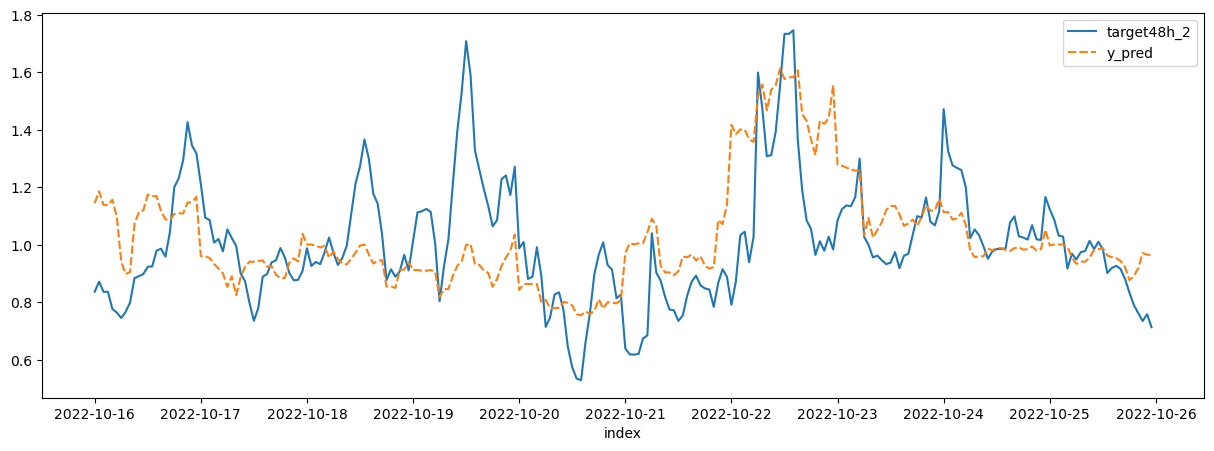

In [443]:
feats = list(df_48_1_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_2'
result, eli_result, df_predicted = check_log_model_regr(df_48_1_v, feats, col_target, 
    CatBoostRegressor(depth=5, iterations=50, loss_function='RMSE', learning_rate=0.1, random_state=0, verbose=False), cv=10)

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


(0.15851722473486912, 0.08780030583537231)


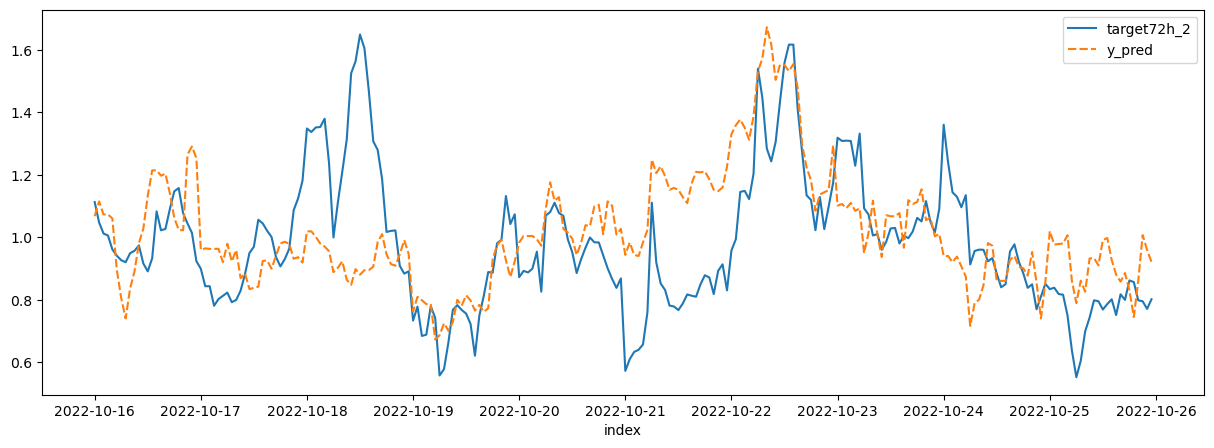

In [337]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_2'
result, eli_result, df_predicted = check_log_model_regr(df_72_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), count_between=48, cv=10)

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


(0.1419730988524988, 0.07915403358310412)


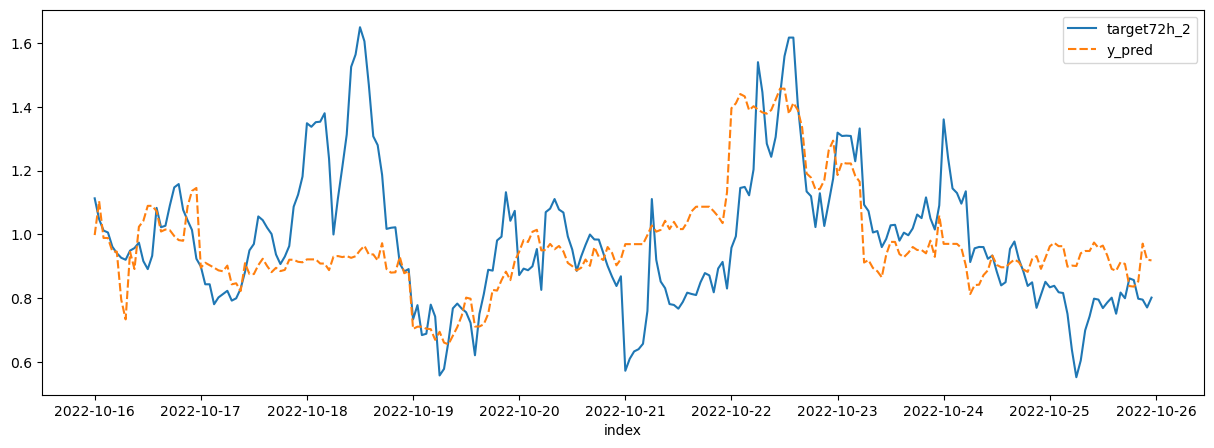

In [338]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_2'
result, eli_result, df_predicted = check_log_model_regr(df_72_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.1, random_state=0), count_between=48, cv=10)

100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


(0.1611560175125184, 0.09486563849001747)


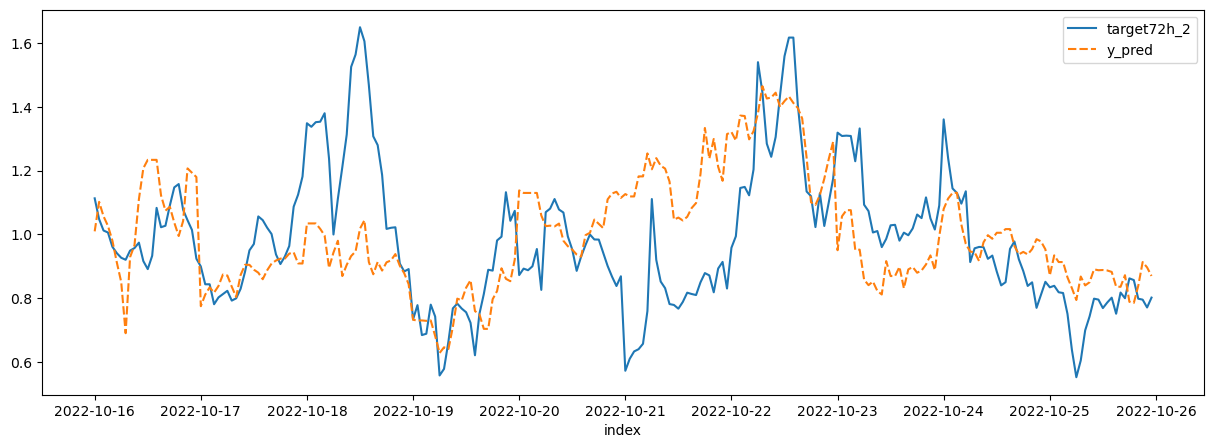

In [445]:
feats = list(df_48_1_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_2'
result, eli_result, df_predicted = check_log_model_regr(df_48_1_v, feats, col_target, 
    xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.15, random_state=0), cv=10)

## Target3 - 48/72H/48v3 - Catboost/XGBoost

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


(0.5708333333333333, array([[87, 48],
       [55, 50]], dtype=int64))


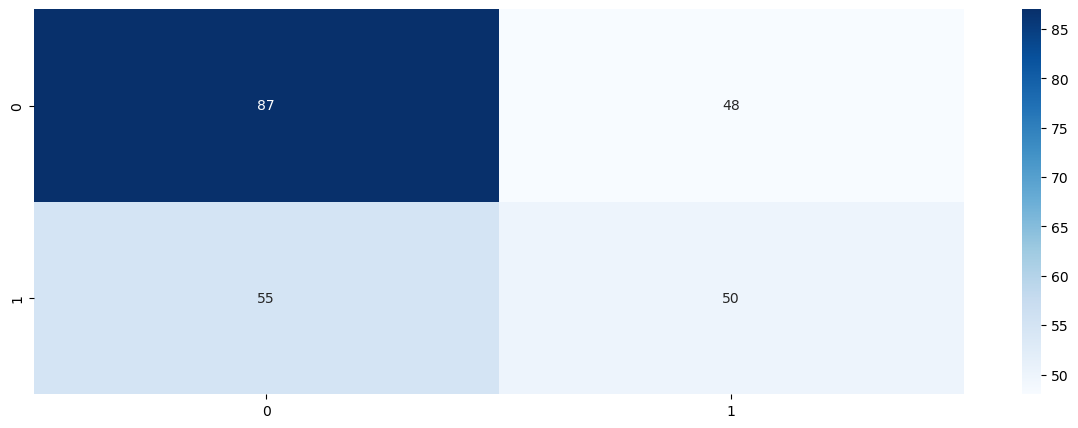

In [353]:
feats = list(df_48_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_3'
result, eli_result, df_predicted = check_log_model_class(df_48_v, feats, col_target, 
    xgb.XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.1, random_state=0), cv=10)

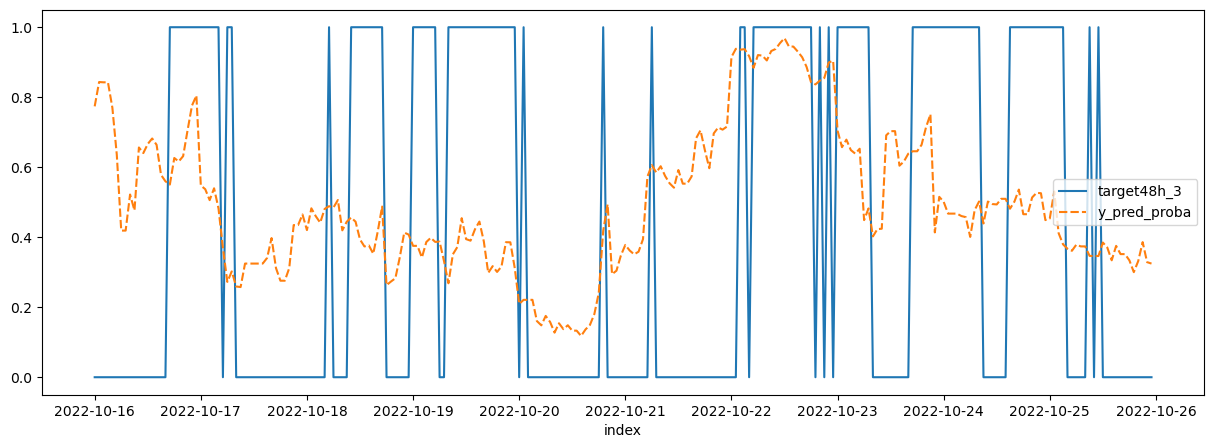

In [354]:
sns.lineplot(data=df_predicted);  

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


(0.5791666666666666, array([[105,  30],
       [ 71,  34]], dtype=int64))


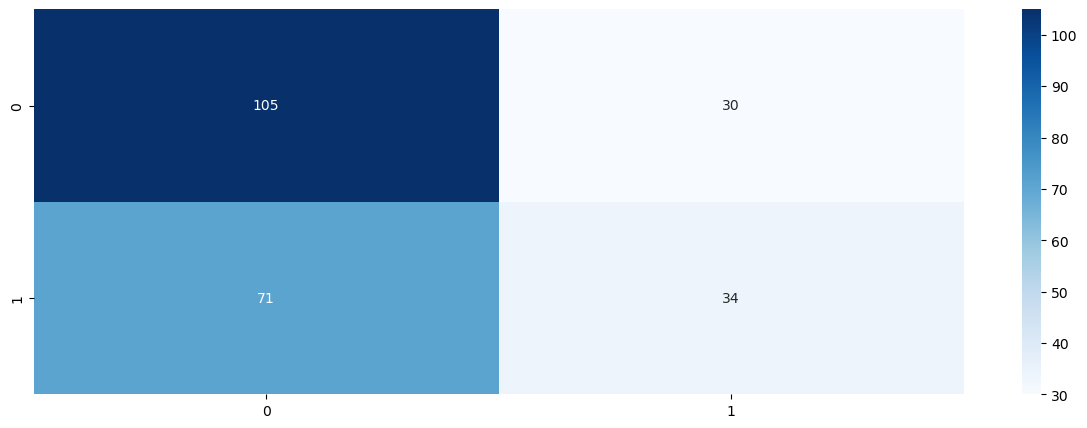

In [448]:
feats = list(df_48_1_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_3'
result, eli_result, df_predicted = check_log_model_class(df_48_1_v, feats, col_target, 
    xgb.XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.1, random_state=0), cv=10)

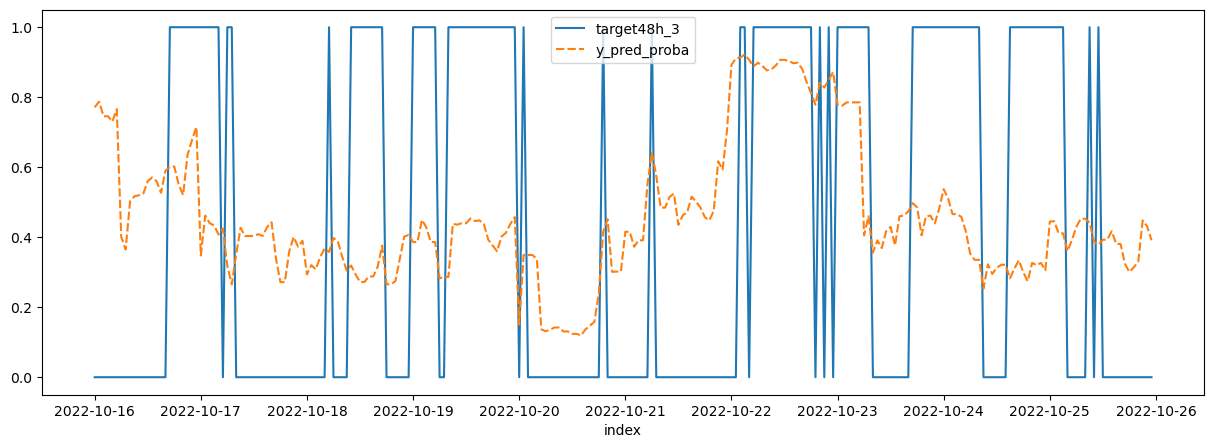

In [449]:
sns.lineplot(data=df_predicted); 

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


(0.6625000000000001, array([[97, 38],
       [43, 62]], dtype=int64))


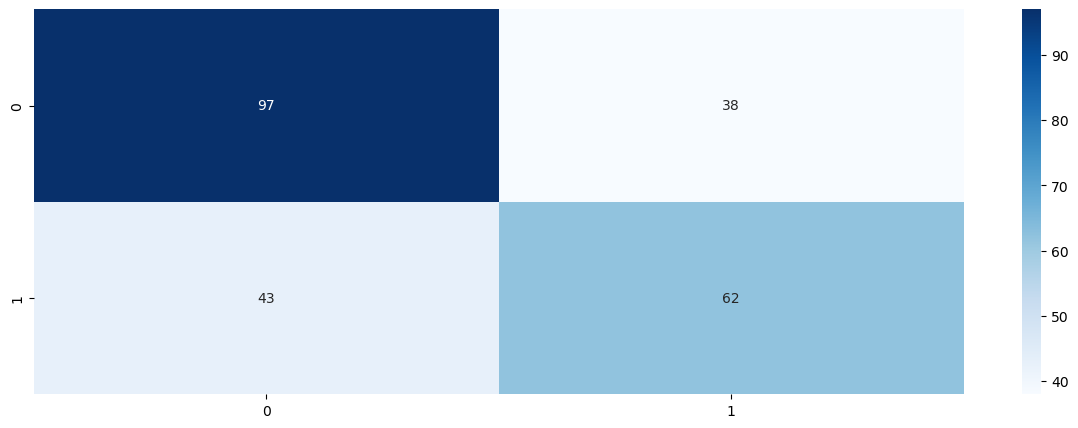

In [367]:
feats = list(df_48_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_3'
result, eli_result, df_predicted = check_log_model_class(df_48_v, feats, col_target, 
    CatBoostClassifier(depth=5, iterations=200, loss_function='Logloss', learning_rate=0.3, random_state=0, verbose=False), cv=10)

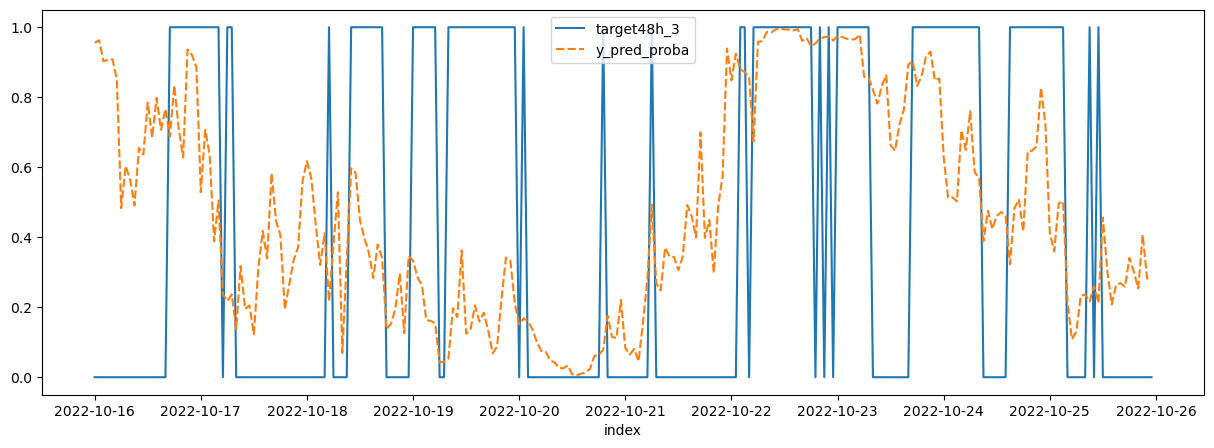

In [368]:
sns.lineplot(data=df_predicted);  

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


(0.7583333333333332, array([[125,  17],
       [ 41,  57]], dtype=int64))


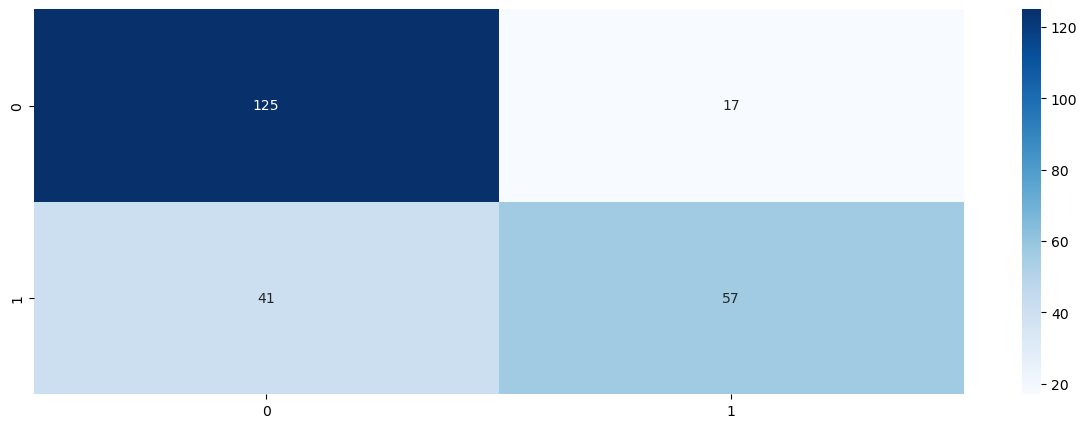

In [370]:
feats = list(df_72_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target72h_3'
result, eli_result, df_predicted = check_log_model_class(df_72_v, feats, col_target, 
    CatBoostClassifier(depth=5, iterations=200, loss_function='Logloss', learning_rate=0.3, random_state=0, verbose=False), count_between=48, cv=10)

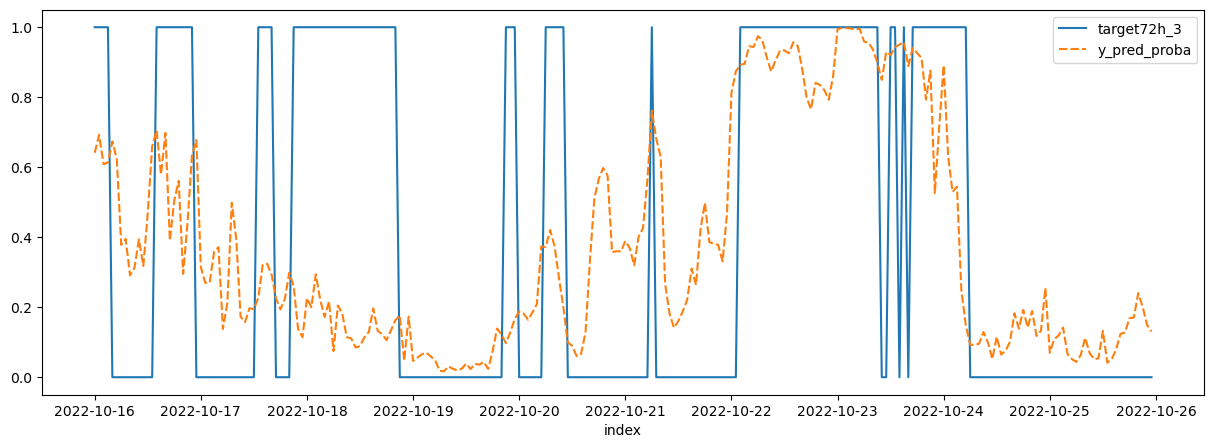

In [371]:
sns.lineplot(data=df_predicted);  

100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


(0.6124999999999999, array([[92, 43],
       [50, 55]], dtype=int64))


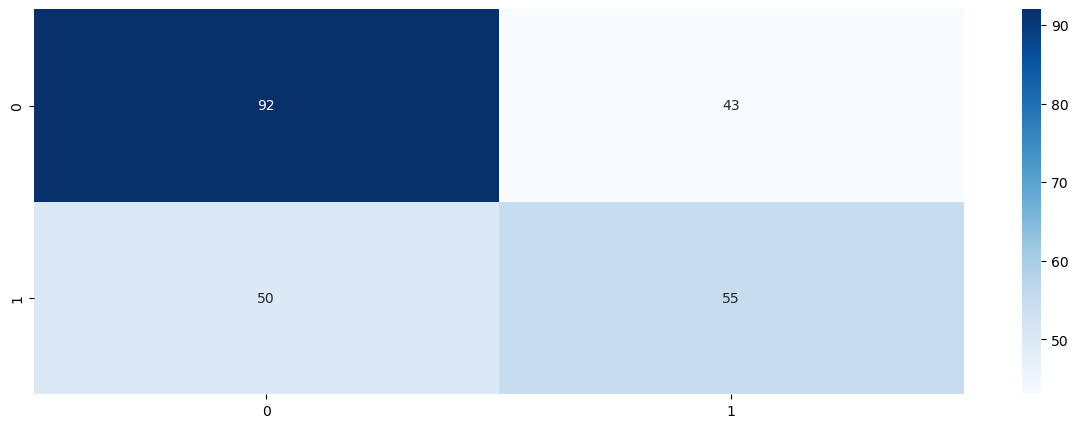

In [456]:
feats = list(df_48_1_v.drop(list_targets+['Main','Description'], axis=1).columns) 
col_target='target48h_3'
result, eli_result, df_predicted = check_log_model_class(df_48_1_v, feats, col_target, 
    CatBoostClassifier(depth=5, iterations=200, loss_function='Logloss', learning_rate=0.3, random_state=0, verbose=False), cv=10)

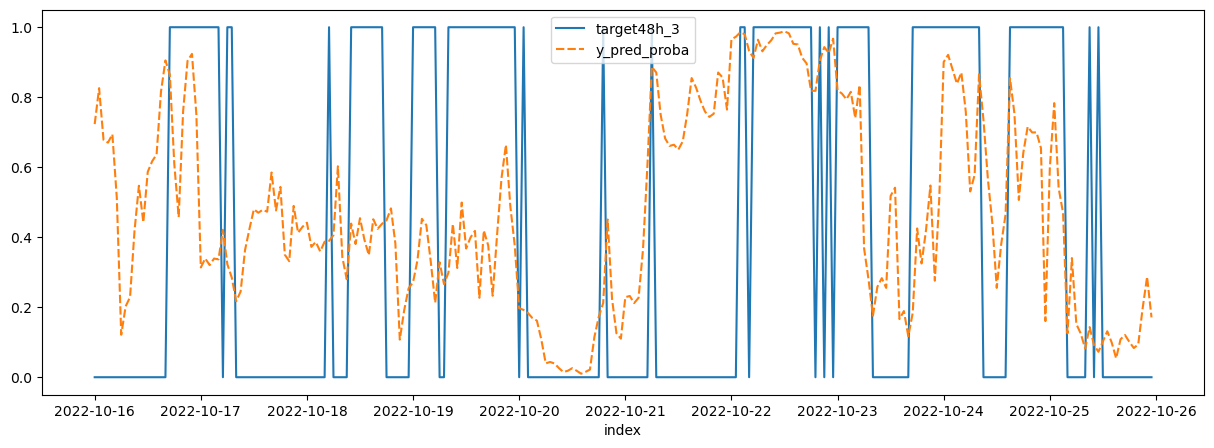

In [457]:
sns.lineplot(data=df_predicted);  